In [1]:
from __future__ import division, print_function

%load_ext autoreload
%autoreload 2

IMAGE_HEIGHT = 75
IMAGE_WIDTH = 75

import scipy
import theano
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import PrintLayerInfo
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum



from util import Util

from theano.sandbox.cuda import dnn

print ('CuDNN support:', dnn.dnn_available())

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)


CuDNN support: True


/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)            
            
def float32(k):
    return np.cast['float32'](k)            

In [3]:
X_train, y_train, X_test, y_test = Util.load('patches_binary_border')

Loading data..


In [4]:
input_rgba = np.concatenate((X_train['image'], X_train['prob'], X_train['merged_array'], X_train['larger_border_overlap']), 1)

In [5]:
test_rgba = np.concatenate((X_test['image'], X_test['prob'], X_test['merged_array'], X_test['larger_border_overlap']), 1)

In [7]:
net0 = NeuralNet(
    layers=[
        ('image', layers.InputLayer),
#         ('image_conv1', layers.Conv2DLayer),
        ('image_conv1', layers.dnn.Conv2DDNNLayer),
        ('image_pool1', layers.MaxPool2DLayer),
#         ('image_dropout1', layers.DropoutLayer),
#         ('image_conv2', layers.Conv2DLayer),
        ('image_conv2', layers.dnn.Conv2DDNNLayer),
        ('image_pool2', layers.MaxPool2DLayer),
#         ('image_dropout2', layers.DropoutLayer),

        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        ('output', layers.DenseLayer),
    ],

    # image
    image_shape=(None, 4, 75, 75),
    # conv2d + pool + dropout
    image_conv1_filter_size=(13,13), image_conv1_num_filters=16,
    image_pool1_pool_size=(2,2),
#     image_dropout1_p=0.1,
    # conv2d + pool + dropout
    image_conv2_filter_size=(13,13), image_conv2_num_filters=16,
    image_pool2_pool_size=(2,2),
#     image_dropout2_p=0.2,

    # dense layer 1
    hidden3_num_units=256,
    hidden3_nonlinearity=nonlinearities.rectify,
    dropout3_p=0.5,

    # dense layer 2
    output_num_units=2,
    output_nonlinearity=nonlinearities.softmax,



    update=nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
#     update_learning_rate=theano.shared(float32(0.03)),
#     update_momentum=theano.shared(float32(0.9)),


    train_split=TrainSplit(eval_size=0.25),
    max_epochs=300,
    verbose=True,

    on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=30),
    ]
)

net0_fit = net0.fit(input_rgba,
                     y_train.astype(np.uint8))

# Neural Network with 386658 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  image        4x75x75
  1  image_conv1  16x63x63
  2  image_pool1  16x31x31
  3  image_conv2  16x19x19
  4  image_pool2  16x9x9
  5  hidden3      256
  6  dropout3     256
  7  output       2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.55167       0.43866      1.25762      0.79811  22.33s
      2       0.43177       0.41186      1.04835      0.81744  22.61s
      3       0.41119       0.39598      1.03843      0.82281  21.46s
      4       0.39535       0.38248      1.03364      0.82752  20.95s
      5       0.38480       0.37610      1.02311      0.82990  21.25s
      6       0.37652       0.36678      1.02655      0.83715  21.18s
      7       0.36782       0.36064      1.01991      0.83954  21.29s
      8       0.35835       0.35453      1.01079     

In [8]:
net0.score(test_rgba,           
           y_test)

0.8180628272251309

In [9]:
net0_layers = net0.get_all_layers()

<module 'matplotlib.pyplot' from '/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

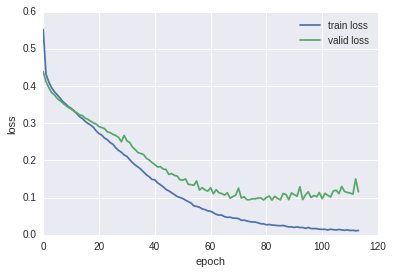

In [10]:
plot_loss(net0)

<module 'matplotlib.pyplot' from '/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

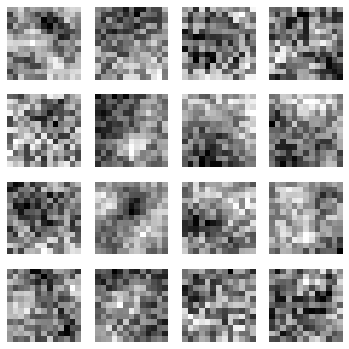

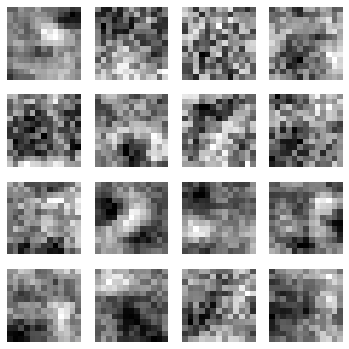

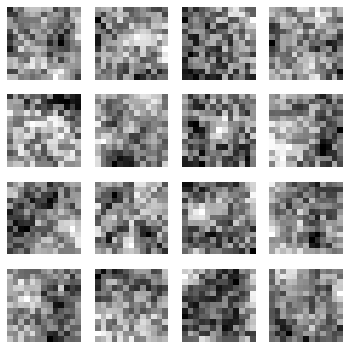

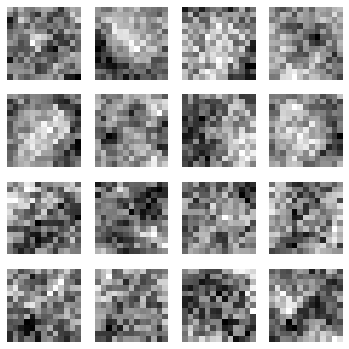

In [11]:
plot_conv_weights(net0_layers[1])

<module 'matplotlib.pyplot' from '/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

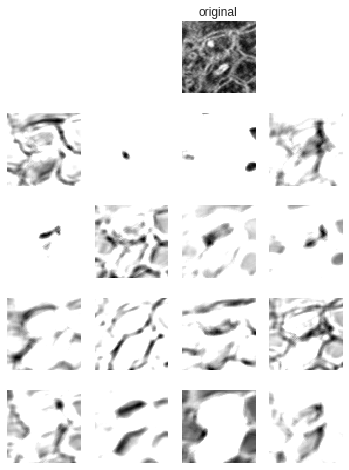

In [16]:
plot_conv_activity(net0_layers[1], test_rgba[0:1].astype(np.float32))